<a href="https://colab.research.google.com/github/Sibahle01/Movie-Recommendation-System-/blob/main/Movie_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files

class NetflixRecommender:
    def __init__(self, file_path='/content/drive/MyDrive/netflix_titles.csv'):
        """Initialize with your file path."""
        self.file_path = file_path
        self.data = None
        self.similarity_matrix = None

    def load_data(self):
        """Load dataset from specified path."""
        try:
            self.data = pd.read_csv(self.file_path)
            print(f"✅ Dataset loaded successfully with {len(self.data)} titles")
            return self.data
        except Exception as e:
            print(f"❌ Error loading '{self.file_path}': {e}\n"
                  "Please ensure: \n"
                  "1. The file exists in Colab's file explorer (left sidebar)\n"
                  "2. The filename is EXACTLY 'netflix_titles.csv'\n"
                  "3. Or update the file_path in NetflixRecommender()")
            return None

    def preprocess(self):
        """Clean and prepare data."""
        if self.data is None:
            self.load_data()


        self.data['director'] = self.data['director'].fillna('Unknown')
        self.data['cast'] = self.data['cast'].fillna('Unknown')
        self.data['description'] = self.data['description'].fillna('')


        self.data['content_features'] = (
            self.data['title'] + ' ' +
            self.data['director'] + ' ' +
            self.data['cast'] + ' ' +
            self.data['listed_in'] + ' ' +
            self.data['description']
        )
        print("✅ Data preprocessed")

    def build_similarity_matrix(self):
        """Create content similarity matrix."""
        if self.data is None:
            self.preprocess()


        tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
        tfidf_matrix = tfidf.fit_transform(self.data['content_features'])
        self.similarity_matrix = cosine_similarity(tfidf_matrix)
        print("✅ Similarity matrix built")

    def recommend(self, title, n=5):
        """Get recommendations for a title."""
        if self.similarity_matrix is None:
            self.build_similarity_matrix()


        title_lower = title.lower()
        matches = self.data[self.data['title'].str.lower() == title_lower]

        if len(matches) == 0:
            print(f"\n⚠️ '{title}' not found. Close matches:")
            close_matches = self.data[
                self.data['title'].str.lower().str.contains(title_lower, na=False)
            ]
            if len(close_matches) > 0:
                print(close_matches['title'].head(3).to_string(index=False))
            else:
                print("Try these popular titles:")
                print(self.data['title'].sample(3).to_string(index=False))
            return None

        idx = matches.index[0]
        sim_scores = list(enumerate(self.similarity_matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        rec_indices = [i[0] for i in sim_scores[1:n+1]]

        return self.data.iloc[rec_indices][['title', 'type', 'release_year', 'rating']]


recommender = NetflixRecommender()

recommender.load_data()
recommender.preprocess()
recommender.build_similarity_matrix()


your_title = "Stranger Things"  # 👈 Change this to any title
recs = recommender.recommend(your_title)

if recs is not None:
    print(f"\n🎬 Recommended because you liked '{your_title}':")
    print(recs.to_string(index=False))


✅ Dataset loaded successfully with 8807 titles
✅ Data preprocessed
✅ Similarity matrix built

🎬 Recommended because you liked 'Stranger Things':
                 title    type  release_year rating
Beyond Stranger Things TV Show          2017  TV-14
            The Sinner TV Show          2020  TV-MA
           Equilibrium   Movie          2002      R
       Sakho & Mangane TV Show          2019  TV-MA
            Safe Haven   Movie          2013  PG-13


Decision Tree Rules:
 |--- release_year <= 2014.50
|   |--- main_genre <= 25.50
|   |   |--- main_genre <= 7.50
|   |   |   |--- weights: [1201.00, 156.00] class: 0
|   |   |--- main_genre >  7.50
|   |   |   |--- weights: [877.00, 229.00] class: 0
|   |--- main_genre >  25.50
|   |   |--- main_genre <= 28.50
|   |   |   |--- weights: [21.00, 48.00] class: 1
|   |   |--- main_genre >  28.50
|   |   |   |--- weights: [49.00, 10.00] class: 0
|--- release_year >  2014.50
|   |--- main_genre <= 4.50
|   |   |--- main_genre <= 3.50
|   |   |   |--- weights: [472.00, 294.00] class: 0
|   |   |--- main_genre >  3.50
|   |   |   |--- weights: [373.00, 1.00] class: 0
|   |--- main_genre >  4.50
|   |   |--- main_genre <= 26.50
|   |   |   |--- weights: [2444.00, 2072.00] class: 0
|   |   |--- main_genre >  26.50
|   |   |   |--- weights: [163.00, 397.00] class: 1



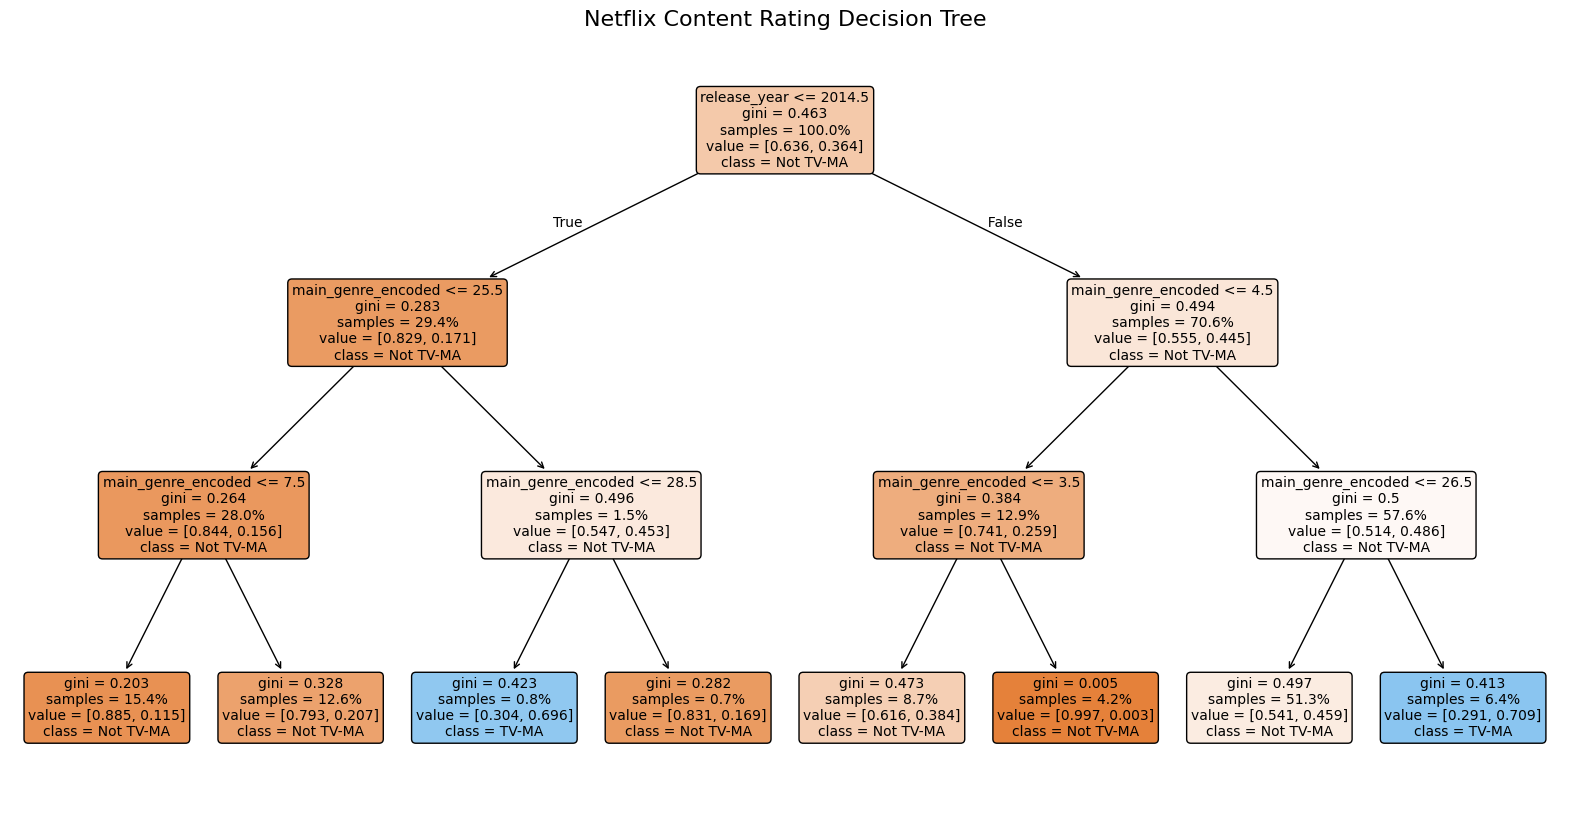

✅ Decision tree saved as 'netflix_decision_tree.png'


In [6]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/netflix_titles.csv')
df = df.fillna({
    'director': 'Unknown',
    'cast': 'Unknown',
    'country': 'Unknown',
    'rating': 'NR'
})


df['is_movie'] = df['type'].apply(lambda x: 1 if x == 'Movie' else 0)
df['duration_min'] = df['duration'].str.extract('(\d+)').astype(float)
df['main_genre'] = df['listed_in'].str.split(',').str[0].str.strip()


le = LabelEncoder()
df['rating_encoded'] = le.fit_transform(df['rating'])
df['main_genre_encoded'] = le.fit_transform(df['main_genre'])


features = ['is_movie', 'release_year', 'duration_min', 'main_genre_encoded']
X = df[features].fillna(0)
y = (df['rating'] == 'TV-MA').astype(int)


dt = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=50,
    random_state=42
)
dt.fit(X, y)


tree_rules = export_text(
    dt,
    feature_names=['is_movie', 'release_year', 'duration_min', 'main_genre'],
    show_weights=True
)
print("Decision Tree Rules:\n", tree_rules)

# Visual Tree Diagram
plt.figure(figsize=(20,10))
plot_tree(
    dt,
    feature_names=features,
    class_names=['Not TV-MA', 'TV-MA'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10
)
plt.title("Netflix Content Rating Decision Tree", fontsize=16)
plt.savefig('netflix_decision_tree.png', bbox_inches='tight', dpi=200)
plt.show()

print("✅ Decision tree saved as 'netflix_decision_tree.png'")